Simple PD controller

In [2]:
import numpy as np
from typing import Union

class PDController():
	def __init__(self,
					kp: Union[float, np.ndarray] = 1.,
					kd: Union[float, np.ndarray] = 1.
					) -> None:
		self.kp = kp
		self.kd = kd
		self.n_act = 1
		
	def set_command(self, q_des: np.ndarray) -> None:
		self.q_des = q_des
		if isinstance(self.q_des, np.ndarray) or isinstance(q_des, list):
			self.n_act = len(self.q_des)
		
	def get_torques(self, q: np.ndarray, v: np.ndarray) -> np.ndarray:
		torques = self.kp * (self.q_des - q[:self.n_act]) + self.kd * (np.zeros_like(v) - v)[:self.n_act]
		return torques

LCP - PGS 

In [3]:
import numpy as np
import mujoco

def get_contact_jacobian_normal(model, data, contact, h, erp):
    """
Return a single-contact normal Jacobian row Jn ∈ R^{1×nv} (as a 1D vector).
Key points:
  - The contact normal is the third "row" of contact.frame (MuJoCo stores t1, t2, n by rows).
  - Relative point linear-velocity Jacobian = Jpos2 - Jpos1 (v_rel = v2 - v1).
  - The Jacobian must be evaluated at the *contact point* (contact.pos), not at the geom centroid.
"""
    # Normal (third row)
    R = contact.frame.reshape(3, 3)
    n = R[2] / (np.linalg.norm(R[2]) + 1e-12)

    # Contact point in world coordinates
    p = np.array(contact.pos)

    # geom -> body
    b1 = model.geom_bodyid[contact.geom1]
    b2 = model.geom_bodyid[contact.geom2]

    # At world point p, compute point linear/angular velocity Jacobians for both bodies
    Jpos1 = np.zeros((3, model.nv)); Jrot1 = np.zeros((3, model.nv))
    Jpos2 = np.zeros((3, model.nv)); Jrot2 = np.zeros((3, model.nv))
    mujoco.mj_jac(model, data, Jpos1, Jrot1, p, b1)
    mujoco.mj_jac(model, data, Jpos2, Jrot2, p, b2)

    # Only need the relative point linear velocity Jacobian
    Jlin_rel = Jpos2 - Jpos1      # 3 x nv

    # Project onto normal: get 1×nv (return as 1D vector)
    Jn = n @ Jlin_rel
    if contact.dist < 0:
        r_test = (Jn @ data.qvel) + erp * contact.dist / h
        if r_test > 0:
            Jn = -Jn
    return Jn


def pgs_solve_lcp(model, data,
                  max_iter=50, tol=1e-6,
                  erp=0.2,                 # Position error correction (ERP)
                  omega=1.0,               # SOR factor (0,2); 1 = standard GS
                  diag_reg=1e-12,          # Diagonal regularization for N
                  zero_separation_bias=True,
                  apply_impulse=True):
    """
Solve the LCP by PGS: 0 ≤ λ ⟂ (N λ + r) ≥ 0
  N = J M^{-1} J^T
  r = J v + bias, bias = erp * min(0, dist) / h (only active when penetrating)
This version handles only the normal direction, no friction.
"""
    ncon = data.ncon
    if ncon == 0:
        return {"iters": 0, "res": 0.0, "ncon": 0}

    nv = model.nv
    h  = model.opt.timestep

    # --- 1) Assemble J and dist
    J = np.zeros((ncon, nv))
    dist = np.zeros(ncon)
    for i in range(ncon):
        c = data.contact[i]
        J[i, :] = get_contact_jacobian_normal(model, data, c, h, erp)
        dist[i] = c.dist

    # --- 2) M、N
    M = np.zeros((nv, nv))
    mujoco.mj_fullM(model, M, data.qM)

    # Solve M X = J^T to get X = M^{-1} J^T (more stable than explicit inverse)
    X = np.linalg.solve(M, J.T)   # nv x ncon
    N = J @ X                     # ncon x ncon

    # --- 3) r = J v + bias
    v = data.qvel.copy()
    bias = erp * np.minimum(0.0, dist) / h if zero_separation_bias else erp * dist / h
    r = J @ v + bias

    # --- 4) PGS main loop
    lam = np.zeros(ncon)
    diag = np.clip(np.diag(N), 0.0, np.inf) + diag_reg
    res = np.inf

    for it in range(max_iter):
        max_step = 0.0
        for i in range(ncon):
            g_i = r[i] + N[i, :].dot(lam)
            li  = lam[i]
            li_new  = li - g_i / (diag[i])        # Unprojected
            li_proj = max(0.0, li_new)            # Project to [0, ∞)
            d = omega * (li_proj - li)            # SOR
            lam[i] = li + d
            if abs(d) > max_step:
                max_step = abs(d)

        # Complementarity residual + iteration step size
        g = r + N @ lam
        comp = np.minimum(lam, g)
        res = max(np.linalg.norm(comp, np.inf), max_step)
        if res < tol:
            break

    # --- 5) Feed the solution back to the system (choose ONE of the two options)
    if apply_impulse:
        # Impulse-corrected velocity: dv = M^{-1} J^T λ = X @ λ
        dv = X @ lam
        data.qvel[:] = data.qvel + dv
    else:
        # Force form (equivalent to spreading impulse over current step): τ = (J^T λ)/h
        tau = (J.T @ lam) / h
        data.qfrc_applied[:] += tau

    return {"iters": it + 1, "res": float(res), "ncon": int(ncon)}

CCP - PGS

In [7]:
import numpy as np
import mujoco

# —— Non-Euclidean friction cone projection (keeps your original behavior; SOC version also available) ——
def cone_proj(lambda_block, mu):
    ln = float(lambda_block[0])
    lt = np.array(lambda_block[1:], dtype=float, copy=True)
    nlt = np.linalg.norm(lt)
    if ln <= 0.0:
        return np.zeros(3, dtype=float)
    if nlt <= mu * ln:
        return np.array([ln, lt[0], lt[1]], dtype=float)
    if nlt < 1e-12:
        return np.array([ln, 0.0, 0.0], dtype=float)
    lt_proj = (mu * ln) * (lt / (nlt + 1e-12))
    return np.array([ln, lt_proj[0], lt_proj[1]], dtype=float)

def cone_proj_soc(lam, mu):
    ln = lam[0]; lt = lam[1:]
    t = np.linalg.norm(lt); a = mu * ln
    if t <= a and ln >= 0: return lam
    if t <= -a:            return np.zeros(3)
    y0 = 0.5 * (t + a)
    if t < 1e-12:          return np.array([y0 / (mu + 1e-12), 0.0, 0.0])
    y = lt * (y0 / (t + 1e-12))
    return np.array([y0 / (mu + 1e-12), y[0], y[1]])

def get_contact_jacobians_ccp(model, data, contact):
    R = contact.frame.reshape(3, 3)
    t1, t2, n = R[0], R[1], R[2]

    p  = np.array(contact.pos)
    b1 = model.geom_bodyid[contact.geom1]
    b2 = model.geom_bodyid[contact.geom2]

    Jpos1 = np.zeros((3, model.nv)); Jrot1 = np.zeros((3, model.nv))
    Jpos2 = np.zeros((3, model.nv)); Jrot2 = np.zeros((3, model.nv))
    mujoco.mj_jac(model, data, Jpos1, Jrot1, p, b1)
    mujoco.mj_jac(model, data, Jpos2, Jrot2, p, b2)

    Jlin_rel = Jpos1 - Jpos2
    Jn  = n  @ Jlin_rel
    Jt1 = t1 @ Jlin_rel
    Jt2 = t2 @ Jlin_rel
    return Jn, Jt1, Jt2

def pgs_solve_ccp(model, data,
                  mu=0.6,
                  max_iter=60,
                  tol=1e-6,
                  erp=0.2,
                  omega=1.0,           # Use 1.0 first for stability
                  diag_reg=1e-8,       # Slightly larger to damp overshoot
                  apply_impulse=True,
                  zero_separation_bias=True,
                  # ↓↓↓ Two new keys that only tune the supporting force ↓↓↓
                  v_bias_max=0.2,      # Max ERP bias pop-out speed (m/s) to prevent overshoot
                  deadzone=1e-5        # ERP deadzone: if |dist| below threshold, do not apply bias
                  ):
    """
min  0.5 * lamᵀ (N + Reg) lam + rᵀ lam
    + 0.5 * k_stick * || (N lam + r)_t ||²
    + 0.5 * k_nb    * || s ||²
    + 0.5 * k_share * Σ_{i<j} (λn_i - λn_j)²
s.t. λn ≥ 0,  ||λt||² - (μ λn)² ≤ 0,
    g_n^{post} ≤ v_target + s,  s ≥ 0
Notes:
  - (N lam + r) is the post-solve constraint velocity (mixed normal/tangent). We penalize only the *tangential* part in the objective.
  - v_target: when penetrating = min(v_bias_max, -erp * dist / h); when not penetrating = 0 (zero rebound).
"""
    ncon = data.ncon
    if ncon == 0:
        return {"iters": 0, "res": 0.0, "ncon": 0}

    nv = model.nv
    h  = model.opt.timestep

    # 1) Build each contact 3xnv Jacobian block J_i
    J_blocks = []
    dist = np.zeros(ncon)
    for i in range(ncon):
        c = data.contact[i]
        Jn, Jt1, Jt2 = get_contact_jacobians_ccp(model, data, c)
        Ji = np.vstack([Jn, Jt1, Jt2])   # 3 x nv
        J_blocks.append(Ji)
        dist[i] = c.dist

    # Stack into big matrix J_stack: (3n x nv)
    J_stack = np.vstack(J_blocks)

    # 2) Mass matrix M and Y = M^{-1} J^T
    M = np.zeros((nv, nv))
    mujoco.mj_fullM(model, M, data.qM)
    Y = np.linalg.solve(M, J_stack.T)     # nv x (3n)

    # 3) r = J v + bias (normal component only), with ERP bias deadzone and rate limiting
    v = data.qvel.copy()
    r_stack = J_stack @ v                 # 3n
    bias_stack = np.zeros(3 * ncon)
    if zero_separation_bias:
        for i in range(ncon):
            d = dist[i]
            if d < -deadzone:
                b = erp * d / h           # Negative (pop outward)
                bias_stack[3*i + 0] = max(-v_bias_max, b)
            else:
                bias_stack[3*i + 0] = 0.0
    else:
        for i in range(ncon):
            b = erp * dist[i] / h
            bias_stack[3*i + 0] = np.clip(b, -v_bias_max, v_bias_max)
    r_stack += bias_stack

    # 4) Precompute N_ii and Ni_full
    Ni_full, N_ii = [], []
    for i in range(ncon):
        Ni = J_blocks[i] @ Y              # 3 x (3n)
        Ni_full.append(Ni)
        cols = slice(3*i, 3*i+3)
        Nii = Ni[:, cols] + diag_reg * np.eye(3)
        N_ii.append(Nii)

    # 5) PGS main loop
    lam = np.zeros(3 * ncon)
    res = np.inf

    for it in range(max_iter):
        max_step = 0.0
        for i in range(ncon):
            ri  = r_stack[3*i:3*i+3].copy()
            gi  = ri + (Ni_full[i] @ lam)          # 3,
            # Compute Δλ_i
            try:
                dlam = -np.linalg.solve(N_ii[i], gi)
            except np.linalg.LinAlgError:
                dlam = -np.linalg.solve(N_ii[i] + 1e-10*np.eye(3), gi)

            lam_i_old = lam[3*i:3*i+3].copy()
            lam_i_try = lam_i_old + omega * dlam

            # Keep your original non-Euclidean projection; to use Euclidean, switch to cone_proj_soc
            lam_i_new = cone_proj(lam_i_try, mu)
            lam[3*i:3*i+3] = lam_i_new

            max_step = max(max_step, float(np.max(np.abs(lam_i_new - lam_i_old))))

        if max_step < tol:
            res = max_step
            break
        res = max_step

    # 6) —— No-bounce: clamp post-impact normal velocity case-wise and keep v_post consistent with lam —— #
    dv = Y @ lam
    v_post = v + dv
    eps = 1e-12

    for i in range(ncon):
        # For convenience, take out block variables first
        Jn  = J_blocks[i][0, :]
        Jt1 = J_blocks[i][1, :]
        Jt2 = J_blocks[i][2, :]

        ln_old = lam[3*i + 0]
        lt_old = lam[3*i + 1:3*i + 3].copy()

        # Normal post-processing (no bounce + limited pop-out when penetrating)
        v_n = float(Jn @ v_post)
        d   = dist[i]
        Nii_nn = float(N_ii[i][0, 0])

        if d <= -1e-6:
            v_target = min(v_bias_max, -erp * d / h)  # Allow separation outward toward target
            if v_n > v_target:
                dlam_n = (v_n - v_target) / (Nii_nn + eps)
                dlam_n = min(dlam_n, lam[3*i + 0])    # Do not pull λn negative
                if dlam_n > 0.0:
                    lam[3*i + 0] -= dlam_n
                    v_post       -= Y[:, 3*i + 0] * dlam_n
        else:
            if v_n > 0.0:  # Zero rebound
                dlam_n = v_n / (Nii_nn + eps)
                dlam_n = min(dlam_n, lam[3*i + 0])
                if dlam_n > 0.0:
                    lam[3*i + 0] -= dlam_n
                    v_post       -= Y[:, 3*i + 0] * dlam_n

        # —— Tangential max-dissipation alignment + friction cone clipping, and update v_post in sync —— #
        ln = lam[3*i + 0]
        # First compute post-solve tangential velocity from current v_post
        vt1 = float(Jt1 @ v_post)
        vt2 = float(Jt2 @ v_post)
        vt  = np.array([vt1, vt2], dtype=float)
        nvt = np.linalg.norm(vt)

        lt_new = lam[3*i + 1:3*i + 3].copy()
        lim = mu * ln

        if ln <= 0.0:
            lt_new[:] = 0.0
        else:
            if nvt > 1e-10:
                # Sliding: put λt on cone boundary and align with -v_t (max dissipation)
                lt_new = -lim * vt / nvt
            else:
                # Approximate static friction: keep if inside cone; scale proportionally if outside
                nlt = np.linalg.norm(lt_new)
                if nlt > lim:
                    lt_new = lt_new * (lim / (nlt + eps))

        # Subtract Δλt effect from v_post to stay consistent
        dlt = lt_new - lt_old
        if np.any(np.abs(dlt) > 0):
            lam[3*i + 1:3*i + 3] = lt_new
            v_post -= Y[:, 3*i + 1] * dlt[0] + Y[:, 3*i + 2] * dlt[1]

    # 7) Feed back to the system (choose one)
    if apply_impulse:
        data.qvel[:] = v_post
    else:
        tau = (J_stack.T @ lam) / h
        data.qfrc_applied[:] = data.qfrc_applied + tau

    return {"iters": it + 1, "res": float(res), "ncon": int(ncon), "lam": lam}

NCP - PGS

In [11]:
import numpy as np
import mujoco

# ========= 1) FB utility =========
def fb_phi(a, b, eps=0.0):
    return np.sqrt(a*a + b*b + 2.0*eps) - (a + b)

def fb_dphi_dlambda(lam, s, Nii, eps=0.0):
    denom = np.sqrt(lam*lam + s*s + 2.0*eps) + 1e-12
    return (lam + s * Nii) / denom - (1.0 + Nii)

def fb_newton_update_scalar(lam_i, b0_i, Nii, eps=1e-12, reg=1e-12, ls_max=8):
    s_i  = b0_i + Nii * lam_i
    phi  = fb_phi(lam_i, s_i, eps)
    dphi = fb_dphi_dlambda(lam_i, s_i, Nii, eps)
    lam_try = max(0.0, lam_i - phi / (dphi + reg))
    merit_old = 0.5 * phi * phi
    for _ in range(ls_max):
        s_try = b0_i + Nii * lam_try
        phi_try = fb_phi(lam_try, s_try, eps)
        if 0.5 * phi_try * phi_try <= merit_old:
            return lam_try
        lam_try = 0.5 * (lam_i + lam_try)
    return lam_try

# ========= 2) Contact normal Jacobian (at contact point) =========
def get_contact_jacobian_normal(model, data, contact):
    R = contact.frame.reshape(3, 3)
    n = R[2] / (np.linalg.norm(R[2]) + 1e-12)
    p  = np.array(contact.pos)
    b1 = model.geom_bodyid[contact.geom1]
    b2 = model.geom_bodyid[contact.geom2]
    Jpos1 = np.zeros((3, model.nv)); Jrot1 = np.zeros((3, model.nv))
    Jpos2 = np.zeros((3, model.nv)); Jrot2 = np.zeros((3, model.nv))
    mujoco.mj_jac(model, data, Jpos1, Jrot1, p, b1)
    mujoco.mj_jac(model, data, Jpos2, Jrot2, p, b2)
    Jlin_rel = Jpos2 - Jpos1
    return n @ Jlin_rel  # (nv,)

# ========= 3) PGS-NCP(FB) + No-bounce =========
def pgs_solve_ncp_fb(model, data,
                              max_iter=80,
                              tol=1e-6,
                              erp=0.2,
                              diag_reg=1e-8,     # Larger than 1e-10 to damp overshoot
                              eps_fb=1e-12,      # FB smoothing
                              v_bias_max=0.2,    # Max pop-out velocity cap for ERP bias (m/s)
                              apply_impulse=True,
                              zero_separation_bias=True,
                              warmstart=None,    # Can pass in last-step λ_n
                              verbose=False):
    ncon = data.ncon
    if ncon == 0:
        return {"iters": 0, "res": 0.0, "ncon": 0, "lam_n": np.zeros(0)}

    nv = model.nv
    h  = model.opt.timestep

    # Assembling J
    Jn_list = []
    dist = np.zeros(ncon)
    for i in range(ncon):
        c = data.contact[i]
        Jn_list.append(get_contact_jacobian_normal(model, data, c))
        dist[i] = c.dist
    J = np.vstack(Jn_list)                    # (ncon x nv)

    # Mass matrix and Y = M^{-1} J^T
    M = np.zeros((nv, nv))
    mujoco.mj_fullM(model, M, data.qM)
    Y = np.linalg.solve(M, J.T)               # (nv x ncon)

    # r = J v + bias (normal ERP clamped)
    v = data.qvel.copy()
    r = J @ v                                 # (ncon,)
    bias = np.zeros(ncon)
    if zero_separation_bias:
        for i in range(ncon):
            if dist[i] < 0.0:
                b = erp * dist[i] / h         # dist<0 -> negative
                bias[i] = max(-v_bias_max, b) # Clamp to [-v_bias_max, 0]
    else:
        for i in range(ncon):
            b = erp * dist[i] / h
            bias[i] = np.clip(b, -v_bias_max, v_bias_max)
    r += bias

    # Delassus: rows of Ni_full, diagonal Nii
    Ni_full = []
    Nii = np.zeros(ncon)
    for i in range(ncon):
        Ni = Jn_list[i] @ Y                   # (ncon,)
        Ni_full.append(Ni)
        Nii[i] = Ni[i] + diag_reg

    # PGS-NCP (FB) loop
    lam = np.zeros(ncon) if warmstart is None else warmstart.copy()
    res = np.inf
    for it in range(max_iter):
        max_step = 0.0
        for i in range(ncon):
            gi   = r[i] + float(Ni_full[i] @ lam)     # g_i(λ)
            b0_i = gi - Nii[i] * lam[i]               # Remove self term
            lam_old = lam[i]
            lam_new = fb_newton_update_scalar(lam_old, b0_i, Nii[i],
                                              eps=eps_fb, reg=1e-12, ls_max=8)
            lam[i] = lam_new
            max_step = max(max_step, abs(lam_new - lam_old))
        res = max_step
        if verbose:
            print(f"[NCP] it={it:02d} step={res:.3e}")
        if res < tol:
            break

    # ---- No-bounce post-projection: enforce v_n^post <= 0 ----
    # Compute post-solve velocity using current λ
    dv = Y @ lam
    v_post = v + dv
    for i in range(ncon):
        v_n_post = float(Jn_list[i] @ v_post)
        if v_n_post > 0.0:
            # Rollback Δλ_n = v_n_post / Nii (do not make λ_n negative)
            dlam = v_n_post / (Nii[i] + 1e-12)
            dlam = min(dlam, lam[i])
            if dlam > 0.0:
                lam[i] -= dlam
                v_post -= Y[:, i] * dlam    # Update post-impact velocity accordingly

    # ---- Feedback (choose one) ----
    if apply_impulse:
        data.qvel[:] = v_post               # Use the velocity after no-bounce directly
    else:
        tau = (J.T @ lam) / h
        data.qfrc_applied[:] += tau

    return {"iters": it + 1, "res": float(res), "ncon": int(ncon), "lam_n": lam}

Casadi-CCP(ipopt)

In [19]:
import os, sys, pathlib

# Add the conda env DLL directory to PATH (critical on Windows)
libbin = pathlib.Path(sys.prefix) / "Library" / "bin"
os.add_dll_directory(str(libbin))           # Requires Python 3.8+
os.environ["PATH"] = str(libbin) + os.pathsep + os.environ.get("PATH","")

import numpy as np
import mujoco
import casadi as ca

def casadi_solve_ccp_relaxed(
    model, data,
    mu=0.6,
    erp=0.2,
    zero_separation_bias=True,
    v_bias_max=0.3,
    deadzone=1e-6,
    reg_n=1e-6, reg_t=1e-6,        # Delassus regularization (strongly convex)
    k_stick=1e-3,                  # Tangential post-velocity sticking weight (1e-3~1e-2)
    k_nb=1e-2,                     # No-bounce relaxation penalty weight (1e-3~1e-1)
    k_share=0.0,                   # Normal force sharing (0 off; try ~1e-5 to enable lightly)
    ipopt_tol=1e-8, ipopt_max_iter=200,
    warmstart_lam=None,
    apply_impulse=True
):
    """
    min  0.5*lamᵀ (N+Reg) lam + rᵀ lam
        + 0.5*k_stick * || (N lam + r)_t ||²
        + 0.5*k_nb    * || s ||²
        + 0.5*k_share * Σ_{i<j} (λn_i - λn_j)²
    s.t. λn ≥ 0,  ||λt||² - (μ λn)² ≤ 0,
        g_n^{post} ≤ v_target + s,  s ≥ 0
    """
    ncon = data.ncon
    if ncon == 0:
        return {"status": "no_contact", "ncon": 0}

    nv = model.nv
    h  = model.opt.timestep

    # 1) Assemble J_stack and dist
    J_blocks, dist = [], np.zeros(ncon)
    for i in range(ncon):
        c = data.contact[i]
        # Note: we keep your existing contact Jacobian function here
        R = c.frame.reshape(3,3); t1,t2,n = R[0],R[1],R[2]
        p  = np.array(c.pos)
        b1 = model.geom_bodyid[c.geom1]; b2 = model.geom_bodyid[c.geom2]
        Jpos1 = np.zeros((3, model.nv)); Jrot1 = np.zeros((3, model.nv))
        Jpos2 = np.zeros((3, model.nv)); Jrot2 = np.zeros((3, model.nv))
        mujoco.mj_jac(model, data, Jpos1, Jrot1, p, b1)
        mujoco.mj_jac(model, data, Jpos2, Jrot2, p, b2)
        Jlin_rel = Jpos2 - Jpos1          # v_rel = v2 - v1
        Jn  = n  @ Jlin_rel
        Jt1 = t1 @ Jlin_rel
        Jt2 = t2 @ Jlin_rel
        J_blocks.append(np.vstack([Jn, Jt1, Jt2]))
        dist[i] = c.dist
    J_stack = np.vstack(J_blocks)          # (3n x nv)

    # 2) Mass matrix, Y, and Delassus
    M = np.zeros((nv, nv)); mujoco.mj_fullM(model, M, data.qM)
    Y = np.linalg.solve(M, J_stack.T)      # (nv x 3n)
    N = J_stack @ Y                        # (3n x 3n)

    # 3) r = J v + bias (normal only; deadzone + rate limiting)
    v = data.qvel.copy()
    r = J_stack @ v
    if zero_separation_bias:
        for i in range(ncon):
            d = dist[i]
            if d < -deadzone:
                r[3*i + 0] += max(-v_bias_max, erp * d / h)
    else:
        for i in range(ncon):
            r[3*i + 0] += np.clip(erp * dist[i] / h, -v_bias_max, v_bias_max)

    # 4) N_reg (strong convex regularization for objective); numeric symmetrization
    reg = np.zeros(3*ncon)
    for i in range(ncon):
        reg[3*i+0] += reg_n; reg[3*i+1] += reg_t; reg[3*i+2] += reg_t
    N_reg = N + np.diag(reg); N_reg = 0.5*(N_reg + N_reg.T)

    # Diagnostics
    for name, arr in [("M",M),("Y",Y),("N",N),("N_reg",N_reg),("r",r)]:
        if not np.all(np.isfinite(arr)): raise RuntimeError(f"{name} has NaN/Inf")

    # 5) Variables: lam(3n) + s(n) (no-bounce relaxation)
    lam = ca.MX.sym("lam", 3*ncon)
    s   = ca.MX.sym("s",   ncon)       # s >= 0
    z   = ca.vertcat(lam, s)

    # Basic quantities
    Hreg = ca.DM(N_reg)
    N_ca = ca.DM(N)         # Form post-impact velocity using physical N
    r_ca = ca.DM(r)
    g_post = ca.mtimes(N_ca, lam) + r_ca    # 3n vector: stack [g_n, g_t1, g_t2]

    # 6) Objective
    f = 0.5*ca.mtimes([lam.T, Hreg, lam]) + ca.dot(r_ca, lam)

    # 6.1 Sticking penalty: penalize only tangential components of post-impact velocity
    if k_stick > 0:
        vt_idx = []
        for i in range(ncon):
            vt_idx.extend([3*i+1, 3*i+2])
        vt = ca.vcat([g_post[k] for k in vt_idx])  # 2n
        f = f + 0.5 * k_stick * ca.dot(vt, vt)

    # 6.2 No-bounce relaxation penalty
    if k_nb > 0:
        f = f + 0.5 * k_nb * ca.dot(s, s)

    # 6.3 Normal force sharing (optional): discourage large λn differences within a contact patch
    if k_share > 0 and ncon >= 2:
        ln = lam[0::3]  # Take the normal component of each contact
        share_sum = 0
        # Fully connected / or adjacency pairs (use fully connected here; OK when ncon is small)
        for i in range(ncon):
            for j in range(i+1, ncon):
                share_sum = share_sum + (ln[i] - ln[j])**2
        f = f + 0.5 * k_share * share_sum

    # 7) Constraints
    g_list, lbg, ubg = [], [], []
    lbx = [-ca.inf]*(3*ncon) + [0.0]*ncon   # s >= 0
    ubx = [ ca.inf]*(3*ncon + ncon)

    # 7.1 λn ≥ 0
    for i in range(ncon):
        # Use variable lower bounds to express
        lbx[3*i + 0] = 0.0

    # 7.2 Quadratic cone: ||λt||² - (μ λn)² ≤ 0
    for i in range(ncon):
        ln_i = lam[3*i + 0]
        lt_i = lam[3*i + 1:3*i + 3]
        g_sq = ca.sumsqr(lt_i) - (mu * ln_i)**2
        g_list.append(g_sq); lbg.append(-ca.inf); ubg.append(0.0)

    # 7.3 Soft no-bounce: g_n_post ≤ v_target + s_i
    v_target = np.zeros(ncon)
    for i in range(ncon):
        d = dist[i]
        if d < -deadzone:
            v_target[i] = min(v_bias_max, -erp * d / h)   # Allow separation outward toward target
        else:
            v_target[i] = 0.0                             # No penetration: zero rebound
        gn_i = g_post[3*i + 0]
        cons = gn_i - (v_target[i] + s[i])                # ≤ 0
        g_list.append(cons); lbg.append(-ca.inf); ubg.append(0.0)

    g = ca.vertcat(*g_list) if g_list else ca.MX.zeros(0,1)

    # 8) Solver (prefer ipopt, fallback to sqpmethod)
    nlp = {"x": z, "f": f, "g": g}
    try:
        solver = ca.nlpsol("solver", "ipopt", nlp, {
            "ipopt.tol": ipopt_tol,
            "ipopt.max_iter": ipopt_max_iter,
            "ipopt.print_level": 0,
            "print_time": 0,
            # "ipopt.linear_solver": "mumps",
        })
    except RuntimeError:
        solver = ca.nlpsol("solver", "sqpmethod", nlp, {
            "qpsol": "qrqp",
            "expand": True,
            "max_iter": 200,
            "tol": 1e-8,
            "print_time": 0,
        })

    # Initial guess
    if warmstart_lam is None:
        x0 = np.zeros(3*ncon + ncon)
    else:
        x0 = np.zeros(3*ncon + ncon)
        wl = np.asarray(warmstart_lam).reshape(-1)
        x0[:3*ncon] = wl[:3*ncon]

    sol = solver(x0=x0, lbg=lbg, ubg=ubg, lbx=lbx, ubx=ubx)
    z_sol = np.array(sol["x"]).reshape(-1)
    lam_sol = z_sol[:3*ncon]
    # s_sol  = z_sol[3*ncon:]   # can be inspected for debugging

    # 9) Write back
    if apply_impulse:
        dv = Y @ lam_sol
        data.qvel[:] = data.qvel + dv
    else:
        tau = (J_stack.T @ lam_sol) / h
        data.qfrc_applied[:] += tau

    return {
        "status": str(solver.stats().get("return_status","OK")),
        "iter_count": int(solver.stats().get("iter_count",-1)),
        "ncon": int(ncon),
        "lam": lam_sol,
        "obj": float(sol["f"]),
    }

Plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import time


def plot_contacts(model,
				  data,
				  controller=None,
				  discard_contacts_id = [],
				  max_sim_time=1.4):
	n_steps = int(max_sim_time / model.opt.timestep)

	# allocate
	sim_time = np.zeros(n_steps)
	ncon = np.zeros(n_steps)
	force = np.zeros((n_steps,3))    # Sum of all contact forces
	penetration = np.zeros(n_steps)  # Penetration distance of the contact
	forcetorque = np.zeros(6)

	with mujoco.viewer.launch_passive(model, data) as viewer:
	
		# Visualize contact
		viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
		viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
		viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
		
		# tweak scales of contact visualization elements
		model.vis.scale.contactwidth = 0.1
		model.vis.scale.contactheight = 0.03
		model.vis.scale.forcewidth = 0.05
		model.vis.map.force = 0.3
		
		# Close the viewer automatically after 30 wall-seconds.
		i = 0
		start = time.time()
		while viewer.is_running() and i < n_steps:
			step_start = time.time()
			
			# Control loop
			if controller != None:
				torque = np.zeros(model.nu)
				q, v = data.qpos, data.qvel
				torque = controller.get_torques(q, v)
				n_act = model.nu
				data.ctrl = torque[:n_act] # TODO
			
			# mj_step can be replaced with code that also evaluates
			# a policy and applies a control signal before stepping the physics.
			# mujoco.mj_step(model, data)
			
			mujoco.mj_step1(model, data)     # Compute bias and related terms

			# Replace MuJoCo default solver
			pgs_solve_lcp(model, data)    
			# pgs_solve_ccp(model, data)
			# pgs_solve_ncp_fb(model, data)   
			# casadi_solve_ccp_relaxed(model,data)

			mujoco.mj_step2(model, data)	 # Optional: update contacts etc.

			# Pick up changes to the physics state, apply perturbations, update options from GUI.
			viewer.sync()

			# Rudimentary time keeping, will drift relative to wall clock.
			time_until_next_step = model.opt.timestep - (time.time() - step_start)
			if time_until_next_step > 0:
				time.sleep(time_until_next_step)
				
			# iterate over active contacts, save force and distance
			for j, c in enumerate(data.contact):
				# TODO: check if contact geoms are in discard_contacts_id
				if c.geom1 in discard_contacts_id or c.geom2 in discard_contacts_id:
					continue

				mujoco.mj_contactForce(model, data, j, forcetorque)
				force[i] += forcetorque[0:3]
				pen_dist = c.dist
				penetration[i] = min(penetration[i], pen_dist)
				
			# Fill data arrays
			sim_time[i] = data.time
			ncon[i] = data.ncon
			i += 1
			
	# plot
	_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 10))

	lines = ax[0,0].plot(sim_time, force)
	ax[0,0].set_title('contact force')
	ax[0,0].set_ylabel('Newton')
	ax[0,0].legend(iter(lines), ('normal z', 'x', 'y'));

	ax[0,1].plot(sim_time, ncon)
	ax[0,1].set_title('number of contacts')
	ax[0,1].set_yticks(range(6))

	ax[1,0].plot(sim_time, force[:,0])
	ax[1,0].set_title('normal (z) force')
	ax[1,0].set_ylabel('Newton')
	ax[1,0].legend()

	ax[1,1].plot(sim_time, 1000*penetration)
	ax[1,1].set_title('penetration depth')
	ax[1,1].set_ylabel('millimeter')
	ax[1,1].set_xlabel('second')

	plt.tight_layout()
	plt.show()

Play


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


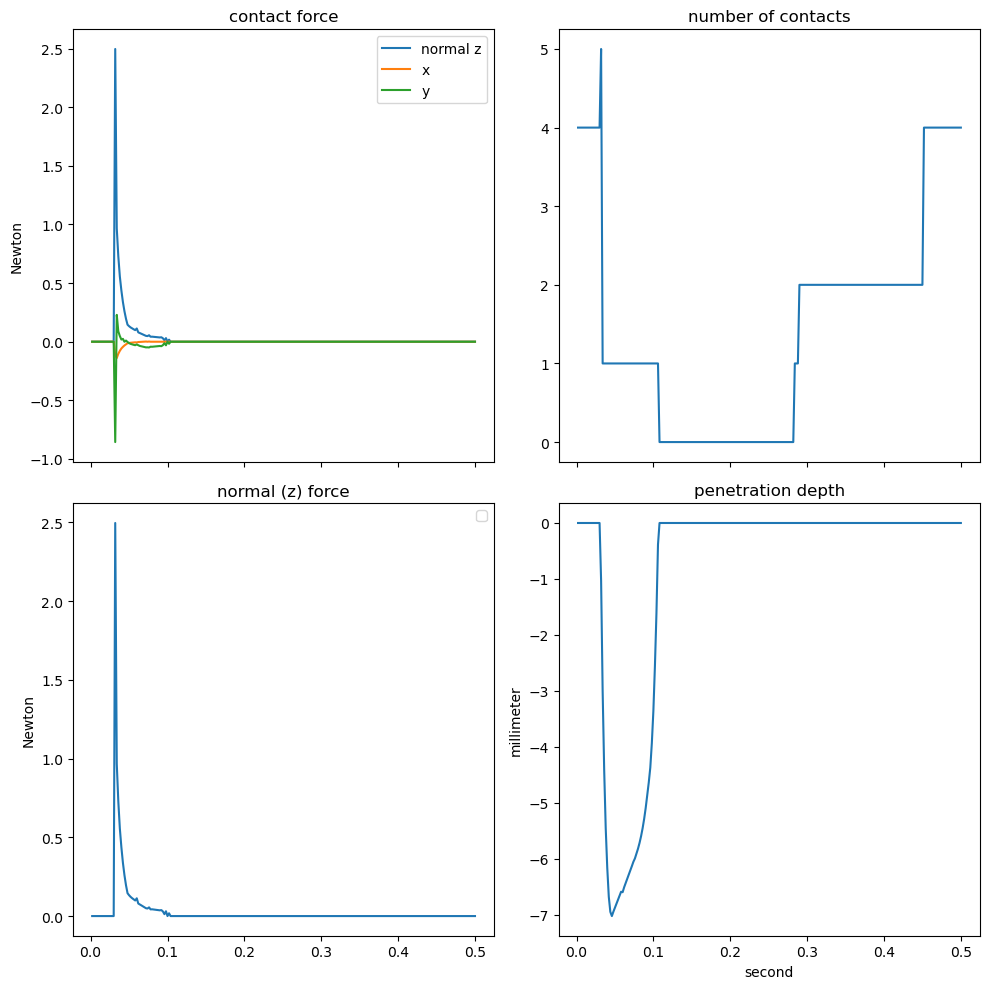

In [21]:
import mujoco
import time
import mujoco.viewer

MODEL_FILE = "../robot_description/finger_edu_description/xml/finger_edu_scene_cube.xml"

model = mujoco.MjModel.from_xml_path(MODEL_FILE)
data = mujoco.MjData(model)

floor_geom_name = 'floor'
floor_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_GEOM, 'floor')

Q_DES = [0., 0., -np.pi/2,] # rad
KP = 1.
KD = 0.07
controller = PDController(KP, KD)
controller.set_command(Q_DES)
plot_contacts(model, data, controller=controller, discard_contacts_id=[floor_id], max_sim_time=0.5)